In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

%matplotlib inline

In [2]:
!nvidia-smi

Tue Oct 13 18:18:03 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 440.82       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Quadro GV100        Off  | 00000000:37:00.0 Off |                  Off |
| 29%   39C    P2    26W / 250W |   3180MiB / 32508MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

loss        0.012039
val_loss    0.042270
dtype: float64


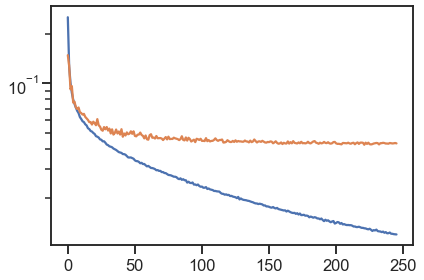

In [3]:
log = pd.read_csv('20201013_redox/log.csv').set_index('epoch')

plt.semilogy(log.loss)
plt.semilogy(log.val_loss)

print(log.min())

plt.tight_layout()
# plt.xlim([0, 10])

In [4]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
import nfp

In [6]:
from preprocess_inputs_spin_bv import preprocessor
preprocessor.from_json('tfrecords_spin_bv/preprocessor.json')

from loss import AtomInfMask, KLWithLogits, RedoxAttention
from nfp import EdgeUpdate, NodeUpdate, GlobalUpdate
import tensorflow_addons as tfa

model = tf.keras.models.load_model(
    '20201013_redox/best_model.hdf5',
    custom_objects={**nfp.custom_objects,
                    **{'EdgeUpdate': EdgeUpdate,
                       'NodeUpdate': NodeUpdate,
                       'GlobalUpdate': GlobalUpdate}})

In [7]:
redox_df = pd.read_csv('/projects/rlmolecule/pstjohn/spin_gnn/redox_data.csv.gz')

In [8]:
redox_df.notna().sum(0)

smiles               94743
ionization energy    51599
electron affinity    83627
oxidized_s2           2355
reduced_s2             216
dtype: int64

In [9]:
data = np.load('redox_split.npz', allow_pickle=True)
redox_valid = redox_df[redox_df.smiles.isin(np.concatenate([data['valid'], data['test']]))]

In [10]:
redox_valid.shape

(2000, 5)

In [33]:
test_dataset = tf.data.Dataset.from_generator(
    lambda: (preprocessor.construct_feature_matrices(smiles, train=False) for smiles in redox_valid.smiles),
    output_types=preprocessor.output_types,
    output_shapes=preprocessor.output_shapes)\
    .padded_batch(batch_size=128, padded_shapes=preprocessor.padded_shapes(),
                  padding_values=preprocessor.padding_values)

In [34]:
predicted_redox = model.predict(test_dataset, verbose=1)

16/16 [==============================] - 1s 68ms/step


Text(0.5, 1.0, 'electron affinity')

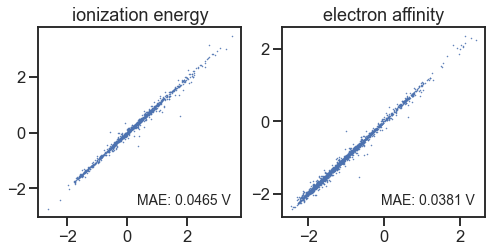

In [35]:
fig, axs = plt.subplots(ncols=2, figsize=(8,3.5))
axs[0].plot(redox_valid['ionization energy'], predicted_redox[:, 0], '.', ms=1)
axs[1].plot(redox_valid['electron affinity'], predicted_redox[:, 1], '.', ms=1)

axs[0].text(.95, .05, f"MAE: {(redox_valid['ionization energy'] - predicted_redox[:, 0]).abs().mean():.4f} V", ha='right', va='bottom', transform=axs[0].transAxes, fontsize=14)
axs[1].text(.95, .05, f"MAE: {(redox_valid['electron affinity'] - predicted_redox[:, 1]).abs().mean():.4f} V", ha='right', va='bottom', transform=axs[1].transAxes, fontsize=14)

axs[0].set_title('ionization energy')
axs[1].set_title('electron affinity')

In [36]:
redox_valid = redox_valid.copy()
redox_valid['pred ionization energy'] = predicted_redox[:, 0]
redox_valid['pred electron affinity'] = predicted_redox[:, 1]

In [37]:
redox_valid['err ionization energy'] = (redox_valid['pred ionization energy'] - redox_valid['ionization energy']).abs()
redox_valid['err electron affinity'] = (redox_valid['pred electron affinity'] - redox_valid['electron affinity']).abs()

/projects/rlmolecule/pstjohn/envs/tf2_gpu/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/projects/rlmolecule/pstjohn/envs/tf2_gpu/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


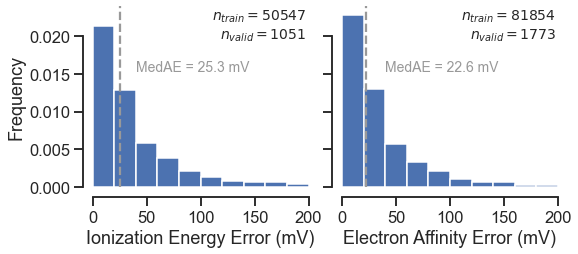

In [38]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 3.5), sharey=True, sharex=True)

axs[0].hist(redox_valid['err ionization energy'] * 1000, range=(0, 200), density=True)
axs[1].hist(redox_valid['err electron affinity'] * 1000, range=(0, 200), density=True)

axs[0].text(.99, .99, f"$n_{{train}} = {len(redox_df[redox_df.smiles.isin(data['train'])]['ionization energy'].dropna())}$\n$n_{{valid}} = {len(redox_valid['err ionization energy'].dropna())}$",
            transform=axs[0].transAxes,
            ha='right', va='top', fontsize=14)

axs[1].text(.99, .99, f"$n_{{train}} = {len(redox_df[redox_df.smiles.isin(data['train'])]['electron affinity'].dropna())}$\n$n_{{valid}} = {len(redox_valid['err electron affinity'].dropna())}$",
            transform=axs[1].transAxes,
            ha='right', va='top', fontsize=14)

med_ae = 1000*redox_valid['err ionization energy'].median()
axs[0].axvline(med_ae, ls='--', color='.6')
axs[0].text(.2, .7, f"MedAE = {med_ae:.1f} mV",
            transform=axs[0].transAxes,
            ha='left', va='top', fontsize=14, color='.6')

axs[1].axvline(1000*redox_valid['err electron affinity'].median(), ls='--', color='.6')
med_ae = 1000*redox_valid['err electron affinity'].median()
axs[1].text(.2, .7, f"MedAE = {med_ae:.1f} mV",
            transform=axs[1].transAxes,
            ha='left', va='top', fontsize=14, color='.6')

axs[0].set_ylabel('Frequency')
axs[0].set_xlabel('Ionization Energy Error (mV)')
axs[1].set_xlabel('Electron Affinity Error (mV)')

axs[0].set_xlim([0, 200])

plt.tight_layout()
sns.despine(trim=True, offset=10)

In [39]:
redox_valid['err ionization energy'].median()

0.02531737766955877

In [18]:
redox_valid['err electron affinity'].median()

0.022583148201900105

In [19]:
spins = pd.read_csv('/projects/rlmolecule/pstjohn/atom_spins/redf_spins_expanded.csv.gz')

In [20]:
spins['fractional_spin'] = spins.groupby('smiles').spin.apply(lambda x: x.abs() / x.abs().sum())

In [21]:
max_fractional_spin = spins.groupby('smiles').fractional_spin.max()

In [22]:
redox_valid_spin = redox_valid.join(max_fractional_spin, on='smiles')

Text(0.5, 1.0, 'Electron Affinity')

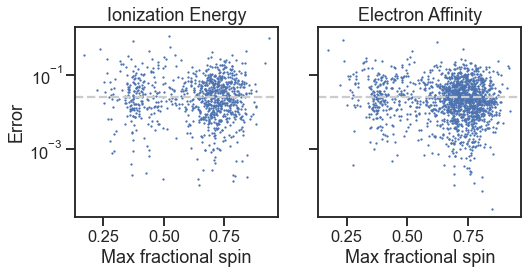

In [23]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8,3.5), sharey=True, sharex=True)
axs[0].semilogy(redox_valid_spin['fractional_spin'], redox_valid_spin['err ionization energy'], '.', ms=2.5)
axs[0].axhline(0.025, ls='--', color='.8')
axs[1].semilogy(redox_valid_spin['fractional_spin'], redox_valid_spin['err electron affinity'], '.', ms=2.5)
axs[1].axhline(0.025, ls='--', color='.8')

axs[0].set_ylabel('Error')
axs[0].set_xlabel('Max fractional spin')
axs[1].set_xlabel('Max fractional spin')

axs[0].set_title('Ionization Energy')
axs[1].set_title('Electron Affinity')

In [25]:
# fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8,3.5), sharey=True, sharex=True)
# axs[0].semilogy(redox_valid_spin['oxidized_rms'], redox_valid_spin['err ionization energy'], '.', ms=2.5)
# axs[0].axhline(0.025, ls='--', color='.8')
# axs[1].semilogy(redox_valid_spin['reduced_rms'], redox_valid_spin['err electron affinity'], '.', ms=2.5)
# axs[1].axhline(0.025, ls='--', color='.8')

# axs[0].set_ylabel('Error')
# axs[0].set_xlabel('RMS')
# axs[1].set_xlabel('RMS')

# axs[0].set_title('Ionization Energy')
# axs[1].set_title('Electron Affinity')

In [26]:
ie_outliers = redox_valid_spin[redox_valid_spin['fractional_spin'] > 0.75].sort_values('err ionization energy', ascending=False).head(3)
ea_outliers = redox_valid_spin[redox_valid_spin['fractional_spin'] > 0.70].sort_values('err electron affinity', ascending=False).head(3)

In [27]:
import psycopg2

dbparams = {
    'dbname': 'bde',
    'port': 5432,
    'host': 'yuma.hpc.nrel.gov',
    'user': 'bdeops',
    'password': 'BD30ps99!',
    'options': f'-c search_path=bde',
}

with psycopg2.connect(**dbparams) as conn:

    redf = pd.read_sql_query("""
    SELECT * from redoxcompound where status='finished'
    """, conn)

In [28]:
ie_outliers[['smiles', 'ionization energy', 'pred ionization energy', 'fractional_spin']]  # oxidized

,smiles,ionization energy,pred ionization energy,fractional_spin
93833,[N]1N=N1,3.047585,2.061290,0.932815
37659,CN(C)c1cc[c][nH]1,-0.090450,0.358120,0.837291
5247,C1N=N[C@@H]2O[C]12,1.702580,1.363614,0.783313


In [29]:
ea_outliers[['smiles', 'electron affinity', 'pred electron affinity', 'fractional_spin']] 

,smiles,electron affinity,pred electron affinity,fractional_spin
63917,C[N+](=[N])C(C)(C)C,0.640161,0.130851,0.730143
23685,CC1=[C]CCCCC1=O,-1.030829,-0.763086,0.722847
55168,C[CH]C(CC)(CC)OO,-1.939481,-1.683886,0.739048


In [198]:
ie_logs = redf[redf.smiles.isin(ie_outliers.smiles) & redf.estate.isin(('radical', 'oxidized'))].logfile
ea_logs = redf[redf.smiles.isin(ea_outliers.smiles) & redf.estate.isin(('radical', 'reduced'))].logfile

In [199]:
# redf[redf.smiles.isin(ie_outliers.smiles) & redf.estate.isin(('radical', 'oxidized'))].sort_values(['smiles', 'estate'])

In [200]:
import shutil

In [201]:
for log in ie_logs:
    shutil.copy(log, '/home/pstjohn/Research/20200608_redox_calculations/spin_gnn/20200918_outliers/ie')

In [202]:
for log in ea_logs:
    shutil.copy(log, '/home/pstjohn/Research/20200608_redox_calculations/spin_gnn/20200918_outliers/ea')

In [ ]:
log

In [ ]:
import os


In [ ]:
ie_logs

In [ ]:
ie_logs.apply(os.path.basename)